# import libraries

In [3]:
#OS libs
import os
import shutil
import itertools
import pathlib

In [1]:
#Data handling tools
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

In [4]:
#Deep learning libs
import tensorflow as tf
from tensorflow import keras
from keras import layers, Model
from keras.models import Sequential, Model
from keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization, GlobalAveragePooling2D, Multiply, Layer, LSTM, Input, multiply, TimeDistributed, Reshape, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam , Adamax
from keras import regularizers

In [5]:
#Warningds
import warnings
warnings.filterwarnings('ignore')

# load data

In [6]:
train_data_path = 'data\Training'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [7]:
train_df

,filepaths,label
0,data\Training\glioma\Tr-glTr_0000.jpg,glioma
1,data\Training\glioma\Tr-glTr_0001.jpg,glioma
2,data\Training\glioma\Tr-glTr_0002.jpg,glioma
3,data\Training\glioma\Tr-glTr_0003.jpg,glioma
4,data\Training\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5195,data\Training\pituitary\Tr-pi_1452.jpg,pituitary
5196,data\Training\pituitary\Tr-pi_1453.jpg,pituitary
5197,data\Training\pituitary\Tr-pi_1454.jpg,pituitary
5198,data\Training\pituitary\Tr-pi_1455.jpg,pituitary


In [8]:
test_data_path = 'data\Testing'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [9]:
test_df

,filepaths,label
0,data\Testing\glioma\Te-glTr_0000.jpg,glioma
1,data\Testing\glioma\Te-glTr_0001.jpg,glioma
2,data\Testing\glioma\Te-glTr_0002.jpg,glioma
3,data\Testing\glioma\Te-glTr_0003.jpg,glioma
4,data\Testing\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1195,data\Testing\pituitary\Te-pi_0295.jpg,pituitary
1196,data\Testing\pituitary\Te-pi_0296.jpg,pituitary
1197,data\Testing\pituitary\Te-pi_0297.jpg,pituitary
1198,data\Testing\pituitary\Te-pi_0298.jpg,pituitary


# Split Test Data into Valid and Test

In [10]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

In [11]:
# Define image size and batch size
img_size = (256, 256)
batch_size = 16

# Create ImageDataGenerator instances for training, validation, and testing
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Create data generators for training, validation, and testing
train_gen = tr_gen.flow_from_dataframe(train_df, 
                                        x_col='filepaths', 
                                        y_col='label', 
                                        target_size = img_size,
                                        class_mode = 'categorical',
                                        color_mode = 'rgb',
                                        shuffle = True,
                                        batch_size = batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid, 
                                        x_col = 'filepaths', 
                                        y_col=  'label', 
                                        target_size = img_size, 
                                        class_modeb = 'categorical',
                                        color_mode = 'rgb', 
                                        shuffle = True, 
                                        batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test, 
                                        x_col = 'filepaths', 
                                        y_col = 'label', 
                                        target_size = img_size, 
                                        class_mode = 'categorical', 
                                        color_mode = 'rgb', 
                                        shuffle = False, 
                                        batch_size = batch_size)


Found 5200 validated image filenames belonging to 4 classes.
Found 600 validated image filenames belonging to 4 classes.
Found 600 validated image filenames belonging to 4 classes.


# Show sample from train data

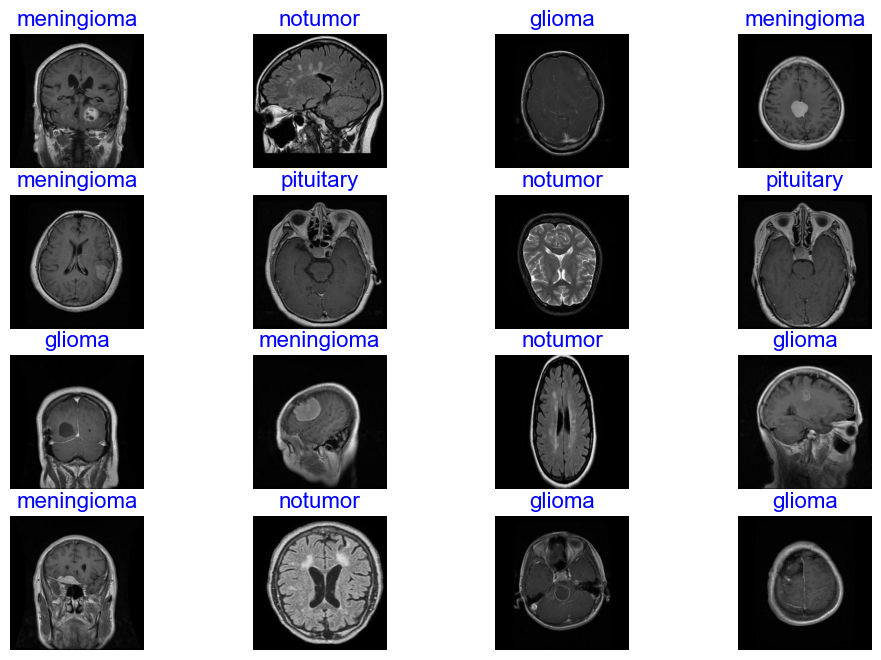

In [12]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (12,8))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 16)
    plt.axis('off')
plt.show()

In [13]:
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

# Model Structure

In [14]:
import keras.backend as K
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [15]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    f1_score,
]

In [16]:
img_shape = (256, 256, 3)
num_class = len(classes)

In [17]:
from keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = img_shape, include_top=False, weights='imagenet')

# Set all layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False
# Set the last vgg block to trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

model = Sequential()
model.add(Input(shape=(256,256,3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_class, activation='softmax'))

In [18]:
model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = METRICS)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dropout (Dropout)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 18909636 (72.13 MB)
Trainable params: 1127

In [19]:
Epochs = 50

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                validation_steps = None , shuffle = False)

Epoch 1/50
325/325 [==============================] - 1848s 6s/step - loss: 1.4070 - accuracy: 0.7555 - precision: 0.5470 - recall: 0.1275 - auc: 0.7073 - f1_score: 0.1900 - val_loss: 1.1510 - val_accuracy: 0.7812 - val_precision: 0.6482 - val_recall: 0.2733 - val_auc: 0.7622 - val_f1_score: 0.3804
Epoch 2/50
325/325 [==============================] - 869s 3s/step - loss: 0.9436 - accuracy: 0.8073 - precision: 0.6980 - recall: 0.4040 - auc: 0.8471 - f1_score: 0.5024 - val_loss: 0.8528 - val_accuracy: 0.8117 - val_precision: 0.7284 - val_recall: 0.3933 - val_auc: 0.8789 - val_f1_score: 0.5082
Epoch 3/50
325/325 [==============================] - 885s 3s/step - loss: 0.7267 - accuracy: 0.8572 - precision: 0.7830 - recall: 0.5933 - auc: 0.9113 - f1_score: 0.6698 - val_loss: 0.7903 - val_accuracy: 0.8562 - val_precision: 0.7392 - val_recall: 0.6567 - val_auc: 0.9056 - val_f1_score: 0.6947
Epoch 4/50
325/325 [==============================] - 896s 3s/step - loss: 0.5939 - accuracy: 0.8876 -

In [20]:
model.save("complete_model.h5")
model.save_weights("model_weights.h5")

# Performace

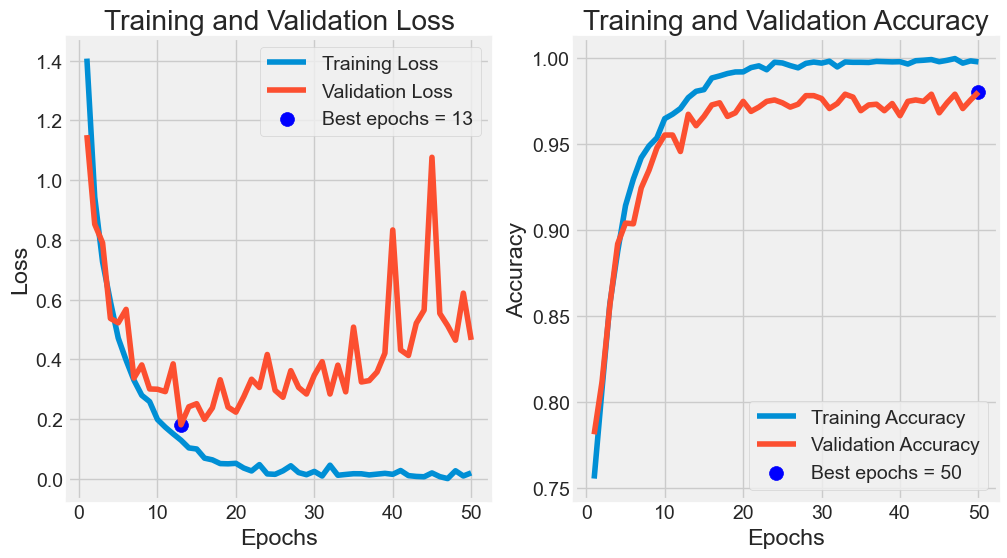

In [23]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (12,6))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss, label = 'Training Loss')
plt.plot(Epochs , val_loss, label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 100, c = 'blue', label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc, label = 'Training Accuracy')
plt.plot(Epochs , val_acc, label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 100 , c = 'blue', label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

# Evaluation

In [24]:
test_loss = model.evaluate(test_gen)
print("Test Loss:", test_loss)

38/38 [==============================] - 75s 2s/step - loss: 0.8049 - accuracy: 0.9712 - precision: 0.9432 - recall: 0.9417 - auc: 0.9771 - f1_score: 0.9432
Test Loss: [0.8049443364143372, 0.9712499976158142, 0.9432387351989746, 0.9416666626930237, 0.9770726561546326, 0.9432300925254822]


In [25]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 34s 2s/step - loss: 0.7140 - accuracy: 0.9717 - precision: 0.9451 - recall: 0.9414 - auc: 0.9796 - f1_score: 0.9433
Train Loss:  0.0013080992503091693
Train Accuracy:  1.0
--------------------
Validation Loss:  0.40621867775917053
Validation Accuracy:  0.984375
--------------------
Test Loss:  0.7140238285064697
Test Accuracy:  0.9716796875


# Predection

In [26]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

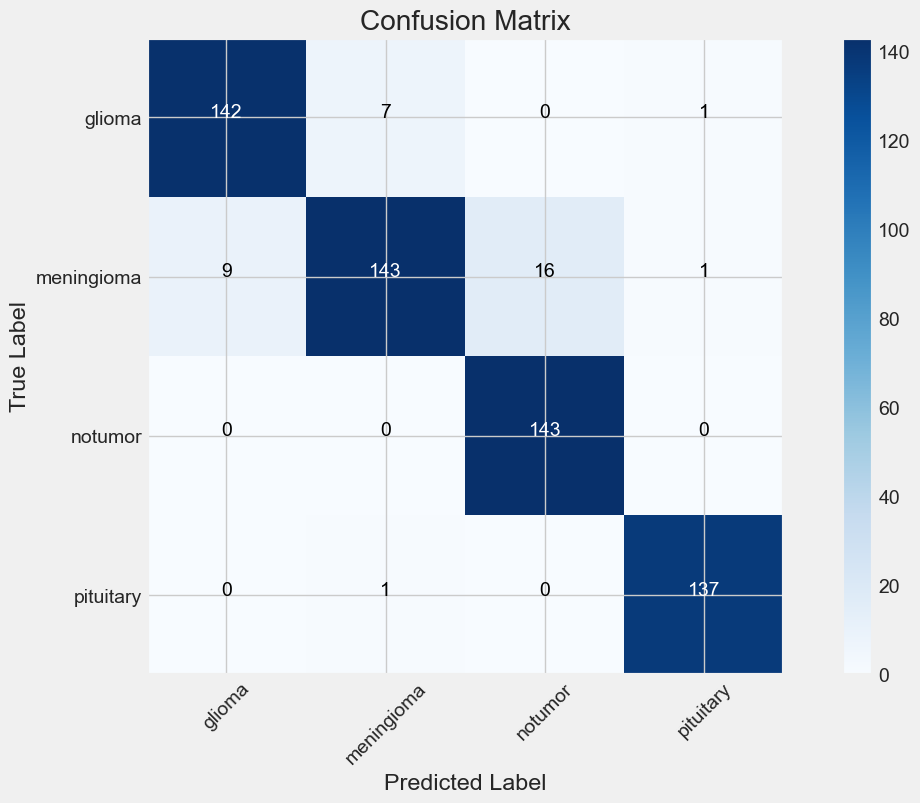

In [27]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (12, 8))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [28]:
#Classification Report
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.94      0.95      0.94       150
  meningioma       0.95      0.85      0.89       169
     notumor       0.90      1.00      0.95       143
   pituitary       0.99      0.99      0.99       138

    accuracy                           0.94       600
   macro avg       0.94      0.95      0.94       600
weighted avg       0.94      0.94      0.94       600



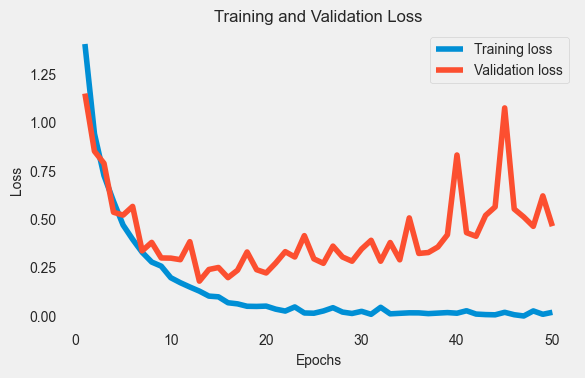

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(6, 4))

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss', fontsize=12)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)
plt.legend(fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.grid(False)

plt.tight_layout()
plt.show()

In [32]:
with tf.keras.utils.custom_object_scope({'f1_score': f1_score}):
    loaded_model = tf.keras.models.load_model("complete_model.h5")
    loaded_model.load_weights("model_weights.h5")
    
def predict(img_path):
    label = list(gen_dict.keys())
    plt.figure(figsize=(6, 8))  # Adjust figure size to accommodate the image and predictions
    
    img = Image.open(img_path)
    resized_img = img.resize((256, 256))
    img = np.asarray(resized_img)
    img = np.expand_dims(img, axis=0)
    img = img / 255
    predictions = loaded_model.predict(img)
    probs = list(predictions[0])
    labels = label
    
    # Find the label with the maximum probability
    max_prob_index = np.argmax(probs)
    max_label = labels[max_prob_index]
    max_prob = probs[max_prob_index]
    
    # Plot image
    plt.imshow(resized_img)
    plt.axis('off')  # Turn off axis
    
    # Print label with maximum probability
    plt.text(0.5, -0.1, f'{max_label}: {max_prob:.2f}', color='blue', fontsize = 16, ha='center', va='center', transform=plt.gca().transAxes)
    
    # Return label and probability
    return max_label, max_prob

In [33]:
from detection import detect_tumor

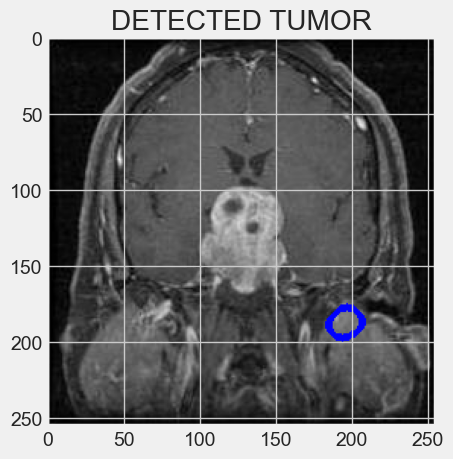

1/1 [==============================] - 1s 571ms/step


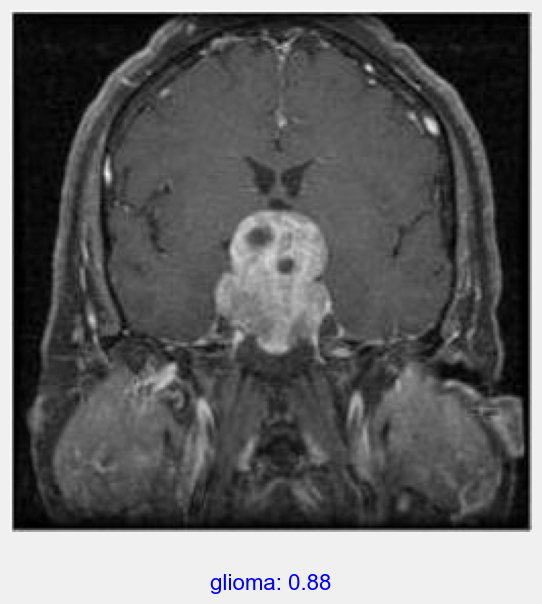

In [38]:
detect_tumor("p.jpg")
max_label, max_prob = predict("p.jpg")
# print("Label with the highest probability:", max_label)
# print("Probability:", max_prob)
